In [164]:
import os
os.sys.path

['/gpfs/workdir/liashuhamy/clr',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python37.zip',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/lib-dynload',
 '',
 '/gpfs/users/liashuhamy/.local/lib/python3.7/site-packages',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/IPython/extensions',
 '/gpfs/users/liashuhamy/.ipython',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages']

In [165]:
os.sys.path.append('/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages')

In [166]:
import numpy as np
import cv2

In [167]:

import tensorflow as tf
print(tf.__version__)

2.3.2


In [168]:
!nvidia-smi

Fri Jul  9 15:15:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:2F:00.0 Off |                    0 |
| N/A   36C    P0    38W / 250W |  31039MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [169]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
# from imutils import paths
from tqdm import tqdm
import tensorflow as tf
# import seaborn as sns
import numpy as np
# import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [170]:
# import h5py

# X_train = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:]
# y_train = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape((-1,1))

# X_test = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:]
# y_test = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape((-1,1))

In [171]:
# from PIL import Image
# def resize(img, size):
#     img = Image.fromarray(img)
#     img = img.resize(size)
#     return np.array(img)

In [172]:
# import cv2
# import numpy as np
# new_x = []
# from tqdm import tqdm
# for i in tqdm(range(X_train.shape[0])):
#     new_x.append(cv2.resize(X_train[i], (224, 224)))
# X_train = np.array(new_x)

# new_x = []
# from tqdm import tqdm
# for i in tqdm(range(X_test.shape[0])):
#     new_x.append(cv2.resize(X_test[i], (224, 224)))
# X_test = np.array(new_x)

# X_train.shape, X_test.shape

In [173]:
# X_train = X_train / 255.
# X_test = X_test / 255.


In [174]:
# _, preprocess_input = Classifiers.get('resnet18')

In [175]:
# X_train[0][:10,:10, 0]

In [176]:
# preprocess_input(X_train[0])[:10,:10, 0]

Data load is here

In [29]:
import h5py

import tensorflow_io as tfio
X_train = tfio.IODataset.from_hdf5('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_train_x.h5', dataset='/x')
y_train = h5py.File('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape((-1,1))
X_test = tfio.IODataset.from_hdf5('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_valid_x.h5', dataset='/x')
y_test = h5py.File('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape((-1,1))

In [177]:
import h5py

import tensorflow_io as tfio
X_train = tfio.IODataset.from_hdf5('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_x.h5', dataset='/x')
y_train = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape((-1,1))
X_test = tfio.IODataset.from_hdf5('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_x.h5', dataset='/x')
y_test = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape((-1,1))

In [178]:
X_train = X_train.map(lambda x: tf.image.resize(x, [224,224]))
X_train = X_train.map(lambda x: tf.cast(x,tf.float32)/255.)
X_train = (
    X_train
    .batch(33)
    .prefetch(tf.data.experimental.AUTOTUNE)
    
)

In [179]:
X_test = X_test.map(lambda x: tf.image.resize(x, [224,224]))
X_test = X_test.map(lambda x: tf.cast(x,tf.float32)/255.)
X_test = (
    X_test
    .batch(28)
    .prefetch(tf.data.experimental.AUTOTUNE)
    
)

In [180]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [181]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [182]:
y_train_enc = np.array([[1-i, i] for i in y_train]).reshape((-1,2))
y_test_enc = np.array([[1-i, i] for i in y_test]).reshape((-1,2))

In [183]:
y_train_enc.shape, y_test_enc.shape

((95106, 2), (30296, 2))

In [184]:
y_test_enc[:3], y_test[:3]

(array([[1, 0],
        [0, 1],
        [0, 1]], dtype=uint8),
 array([[0],
        [1],
        [1]], dtype=uint8))

In [185]:
from classification_models.tfkeras import Classifiers
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
#     projection_2 = Activation("relu")(projection_2)
#     projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_2)

    return resnet_simclr

In [232]:

resnet_simclr = get_resnet_simclr(256,256,256)
resnet_simclr.load_weights('model_18_layers2_256_sgd_c.h5')

# ResNet18, _ = Classifiers.get('resnet18')
# base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# base_model.trainable = True
# inputs = Input((224, 224, 3))
# h = base_model(inputs, training=False)
# h = GlobalAveragePooling2D()(h)
# resnet_simclr = Model(inputs, h)

resnet_simclr.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_69 (Functional)   (None, 7, 7, 512)         11186889  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
Total params: 11,384,009
Trainable params: 11,376,067
Non-trainable params: 7,942
_____________________________________

In [233]:
def plot_training(H):
	with plt.xkcd():
# 		plt.plot(H.history["loss"], label="train_loss")
# 		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [234]:

def get_linear_model(features):
    linear_model = Sequential([Dense(2, input_shape=(features, ), activation="softmax")])
    return linear_model

In [235]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_69 (Functional)   (None, 7, 7, 512)         11186889  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
Total params: 11,384,009
Trainable params: 197,120
Non-trainable params: 11,186,889
___________________________________

In [236]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)


In [237]:
filters = projection.layers[1].layers[3].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [238]:
filters[:,:,:,0]

array([[[0.5027217 , 0.49775854, 0.5023933 ],
        [0.50040925, 0.49197745, 0.49609926],
        [0.513745  , 0.5020411 , 0.5015744 ],
        [0.51454955, 0.50462604, 0.49632236],
        [0.50336325, 0.5021856 , 0.48457167],
        [0.48942065, 0.48746037, 0.48284265],
        [0.5036308 , 0.5017442 , 0.5019774 ]],

       [[0.499196  , 0.5178191 , 0.51577383],
        [0.49320352, 0.5207657 , 0.516273  ],
        [0.4974689 , 0.51946807, 0.5105864 ],
        [0.49707744, 0.50715744, 0.5002879 ],
        [0.51857394, 0.52085626, 0.5044033 ],
        [0.5190216 , 0.5192907 , 0.48638603],
        [0.5246907 , 0.5257553 , 0.5033926 ]],

       [[0.4989806 , 0.53944576, 0.5284663 ],
        [0.46646976, 0.50471956, 0.51665056],
        [0.43883753, 0.47688344, 0.4899135 ],
        [0.4111037 , 0.44079185, 0.44673672],
        [0.41937706, 0.42091414, 0.4406497 ],
        [0.46566725, 0.46113232, 0.47160575],
        [0.52304107, 0.5364611 , 0.52560776]],

       [[0.51097196, 0.54295

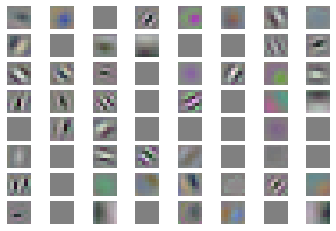

In [239]:
from matplotlib import pyplot as plt
figure, axes = plt.subplots(nrows=8, ncols=8)

i = 0
for x in range(8):
    for y in range(8):
        axes[x, y].imshow(filters[:, :, :, i])
        
        axes[x, y].axis('off')
        i = i + 1
# axes[0, 1].imshow(filters[:, :, :, 1])
# axes[1, 0].imshow(filters[:, :, :, 2])
# axes[1, 1].imshow(filters[:, :, :, 3])
plt.axis('off')
plt.show()

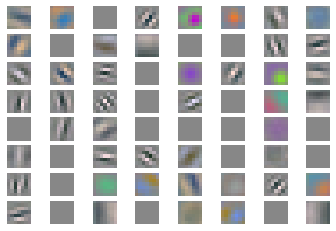

In [223]:
from matplotlib import pyplot as plt
figure, axes = plt.subplots(nrows=8, ncols=8)

i = 0
for x in range(8):
    for y in range(8):
        axes[x, y].imshow(filters[:, :, :, i])
        
        axes[x, y].axis('off')
        i = i + 1
# axes[0, 1].imshow(filters[:, :, :, 1])
# axes[1, 0].imshow(filters[:, :, :, 2])
# axes[1, 1].imshow(filters[:, :, :, 3])
plt.axis('off')
plt.show()

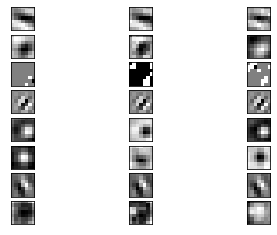

In [224]:
from matplotlib import pyplot
# plot first few filters
n_filters, ix = 8, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
#         plt.figure(figsize=(5,20)) 
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


In [210]:

import time
tic = time.time()
# Extract train and test features
train_features = projection.predict(X_train)
print(train_features.shape)
test_features = projection.predict(X_test)
print(time.time() - tic)

print( test_features.shape)

(95106, 256)
202.3469421863556
(30296, 256)


In [211]:
X_train

<PrefetchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [212]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_features1 = scaler.fit_transform(train_features)
# test_features1 = scaler.transform(test_features)

In [213]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=2, restore_best_weights=True)

In [214]:
linear_model = get_linear_model(256)
linear_model.summary()
linear_model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 2)                 514       
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.4027 - accuracy: 0.8345 - val_loss: 0.4189 - val_accuracy: 0.8240
Epoch 2/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.3732 - accuracy: 0.8453 - val_loss: 0.4238 - val_accuracy: 0.8255
Epoch 3/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.3715 - accuracy: 0.8462 - val_loss: 0.4230 - val_accuracy: 0.8234
Epoch 4/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.3715 - accuracy: 0.8460 - val_loss: 0.4239 - val_accuracy: 0.8258
Epoch 5/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.3711 - accuracy: 0.8453 - val_loss: 0.4224 - val_accuracy: 0.8261
Epoch 6/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.3702 - accuracy: 0.8468 - val_loss: 0.4219 - val_accuracy: 0.8255
Epoch 7/30
1487/1487 [==============================] - 4s 3ms/step - loss: 0.3704 - accuracy: 0.8461 - val_loss: 0.4209 - val_accuracy:

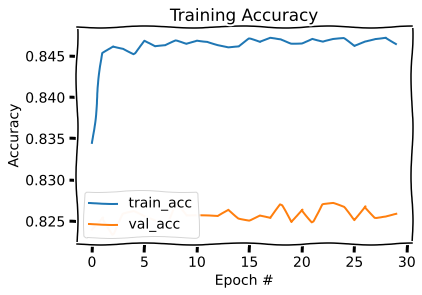

In [215]:
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=30,
                 callbacks=[es])
plot_training(history)

In [40]:
y_train_enc

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [95]:
from sklearn.linear_model import LinearRegression, SGDClassifier
reg = SGDClassifier().fit(train_features, y_train)
reg.score(test_features, y_test)

/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8028782677581199

In [60]:
X_train.shape

AttributeError: 'PrefetchDataset' object has no attribute 'shape'

In [61]:
train_features.shape

(95106, 512)

In [96]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=100).fit(train_features, y_train)
clf.score(test_features, y_test)

/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8101069448111962

In [76]:
clf.score(test_features, y_test)

0.8175666754687088